# 1. Chunk optimization
- Tạo chỉ mục, thêm chỉ mục vào metadata
# 2. Multi-representation Indexing
- Smaller chunks -- ParentDocumentRetriever -- Chia tài liệu thành các thành phần nhỏ hơn
- Summary -- Tóm tắt nội dung tài liệu, nhúng bản tóm tắt
# 3. ColBERT
https://www.youtube.com/watch?v=xTzUn3G9YA0

# 4. RAPTOR
- ý tưởng nhúng và phân cụm tài liệu -> tóm tắt cụm tài liệu -> tiếp tục nhúng và phân cụm các tài liệu tóm tắt..
- cuối cùng thêm tất cả các tài liệu tóm tắt theo cụm vào data ban đầu
- embedding toàn bộ -> retriever 

In [1]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = "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"

# 1. Chunk optimization
https://www.youtube.com/watch?v=8OJC21T2SL4
- 1.1. Character Split
- 1.2. Recursive Character Split
- 1.3. Document Specific Splitting
- 1.4. Semantic Splitting (With Embeddings)

In [13]:
from langchain_text_splitters import CharacterTextSplitter

with open(r"F:\CMC\CMC_Study\Code\data\state_of_the_union.txt", encoding='utf-8') as f:
    text = f.read()
text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=0, separator="", strip_whitespace=False)

text = text_splitter.create_documents([text])
text[0:5]

[Document(page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and th'),
 Document(page_content='e Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. '),
 Document(page_content='This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independent'),
 Document(page_content='s. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Con'),
 Document(page_content='stitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix day')]

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Read the text from the file
with open(r"F:\CMC\CMC_Study\Code\data\state_of_the_union.txt", encoding='utf-8') as f:
    text = f.read()
print(text[:500])
text_splitter = RecursiveCharacterTextSplitter(chunk_size=150, chunk_overlap=0)

text = text_splitter.create_documents([text])
text[0:5]

Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  

Last year COVID-19 kept us apart. This year we are finally together again. 

Tonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. 

With a duty to one another to the American people to the Constitution. 

And with an unwavering resolve that freedom will always triumph over tyranny. 

Six day


[Document(page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My'),
 Document(page_content='fellow Americans.'),
 Document(page_content='Last year COVID-19 kept us apart. This year we are finally together again.'),
 Document(page_content='Tonight, we meet as Democrats Republicans and Independents. But most importantly as Americans.'),
 Document(page_content='With a duty to one another to the American people to the Constitution.')]

In [18]:
import os
import shutil

from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain.schema.document import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores.chroma import Chroma
from langchain_community.embeddings.ollama import OllamaEmbeddings

In [2]:
DATA_PATH = "data"
CHROMA_PATH = "chroma"

In [3]:
# embed
embeddings = OllamaEmbeddings(model="llama3")

In [4]:
# load data
document_loader = PyPDFDirectoryLoader(DATA_PATH)
docs = document_loader.load()

In [5]:
# Spliter
def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

chunks = split_documents(docs)

In [ ]:
#----------------------------------------------------------------------------------------------------
# Add Index

In [6]:
# Lập chỉ mục
def add_to_chroma(chunks: list[Document]):
    # Load the existing database.
    db = Chroma(
        persist_directory=CHROMA_PATH, embedding_function=embeddings
    )

    # Calculate Page IDs.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Add or Update the documents.
    existing_items = db.get(include=[])  # IDs are always included by default
    existing_ids = set(existing_items["ids"])
    
    print(existing_ids)
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    # Only add documents that don't exist in the DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)
    print(new_chunks)
    if len(new_chunks):
        print(f"Adding new documents: {len(new_chunks)}")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
    else:
        print("No new documents to add")
    print(f"Adding new documents: Success")   

def calculate_chunk_ids(chunks):
    # This will create IDs like "data/filename.pdf:6:2"
    # Page Source : Page Number : Chunk Index

    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        page = chunk.metadata.get("page")
        current_page_id = f"{source}:{page}"

        # If the page ID is the same as the last one, increment the index.
        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        # Calculate the chunk ID.
        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id
    return chunks
    
def clear_database():
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

In [ ]:
add_to_chroma(chunks)

In [ ]:
#----------------------------------------------------------------------------------------------------
# query 1

In [8]:
from langchain.prompts import ChatPromptTemplate
from langchain_community.llms.ollama import Ollama


PROMPT_TEMPLATE = """
Answer the question based only on the following context:{context}
---
Answer the question based on the above context: {question}
"""
def query_rag(query_text: str):
    
    # embed
    embedding_function = embeddings
    
    # Prepare the DB.
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    # Search the DB.
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    # print(prompt)

    model = Ollama(model="llama3")
    response_text = model.invoke(prompt)

    sources = [doc.metadata.get("id", None) for doc, _score in results]
    formatted_response = f"Response: {response_text}\nSources: {sources}"
    print(formatted_response)
    return response_text

In [9]:
query = input("Query: ")
while query != "q":
    query_rag(query_text=query)
    query = input("Query: ")

Query:  what is the dataset


Response: According to the provided context, the dataset used contains a diverse range of fire and smoke scenarios, including indoor and outdoor fires, small and large fires, low-light and high-light conditions, and normal scenes without fire. The dataset consists of 26,520 images, divided into 21,216 for training and 5,304 for testing.
Sources: ['data\\yolov8.pdf:10:0', 'data\\yolov8.pdf:13:2', 'data\\yolov8.pdf:11:2', 'data\\yolov8.pdf:15:0', 'data\\yolov8.pdf:7:3']


Query:  q


In [ ]:
#----------------------------------------------------------------------------------------------------
# query 2

In [9]:
from langchain.chains import create_retrieval_chain
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.vectorstores.chroma import Chroma
from langchain_community.llms.ollama import Ollama

from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage
from langchain.chains.history_aware_retriever import create_history_aware_retriever

CHROMA_PATH = "chroma"
DATA_PATH = "data"

embeddings = OllamaEmbeddings(model="llama3")

db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embeddings)

model = Ollama(model="llama3")
prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer the user's questions based on the context: {context}"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}")
])

document_chain = create_stuff_documents_chain(llm=model, prompt=prompt)

retriever = db.as_retriever(search_kwargs={"k": 3})

retriever_prompt = ChatPromptTemplate.from_messages([
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "Given the above conversation, generate a search query to look up in order to get information relevant to the conversation")
])

history_aware_retriever = create_history_aware_retriever(
    llm=model,
    prompt=retriever_prompt,
    retriever=retriever)

retriever_chain = create_retrieval_chain(history_aware_retriever, document_chain)


def process_chat(chain, question, chat_history):
    response = chain.invoke({
        "chat_history": chat_history,
        "input": question,
    })
    return response


if __name__ == "__main__":
    query = input("Query: ")
    chat_history = []
    while query != "q":
        # docs_relevant = retriever.get_relevant_documents(query)
        # print(docs_relevant)
        ans = process_chat(chain=retriever_chain, question=query, chat_history=chat_history)
        chat_history.append(HumanMessage(content=query))
        chat_history.append(AIMessage(content=ans["answer"]))
        print("context: ")
        for docs in ans["context"]:
            print(docs)
            print()
        print('\nAnswer: ', ans["answer"])
        query = input("Query: ")

Query:  what is the dataset?


context: 
page_content='tative of the overall dataset. Other pre-processing steps,\nsuch as resizing or normalizing the data, may also benecessary. The goal is to have a large enough, balanced\ndataset that can generalize well to new data.\nStep 3: Model selection This step involves selecting the\nappropriate object detection algorithm for training the ﬁre\ndetection model. There are several algorithms to choose\nfrom, such as YOLOv8, Faster R-CNN, and SSD, eachwith its own advantages and disadvantages. The selected\nalgorithm should have good performance on the collected\ndataset and be capable of handling different ﬁre scenarios,depending on the requirements of the smart ﬁre detection\nsystem. YOLOv8 is a popular choice due to its speed andaccuracy, but other algorithms can also be used based on\nspeciﬁc needs.' metadata={'id': 'data\\yolov8.pdf:7:1', 'page': 7, 'source': 'data\\yolov8.pdf'}

page_content='costs associated with false alarms.\n•Cost-effective: The proposed approach ma

Query:  q


# 2. Multi-representation Indexing
- Smaller chunks -- ParentDocumentRetriever -- Chia tài liệu thành các thành phần nhỏ hơn - tạo các id duy nhất
- Summary -- Tóm tắt nội dung tài liệu, nhúng bản tóm tắt

In [58]:
# Smaller chunks
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.retrievers import ParentDocumentRetriever

In [59]:
from langchain.storage import InMemoryByteStore
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.document_loaders import TextLoader
# from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [60]:
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_community.llms.ollama import Ollama

embeddings = OllamaEmbeddings(model="llama3")
model = Ollama(model="llama3")

In [61]:
loaders = [
    # TextLoader(r"F:\CMC\CMC_Study\Code\data\paul_graham_essays.txt"),
    TextLoader(r"F:\CMC\CMC_Study\Code\data\state_of_the_union.txt", encoding="utf-8"),
]
docs = []
for loader in loaders:
    docs.extend(loader.load())
text_splitter = RecursiveCharacterTextSplitter(chunk_size=5000)
docs = text_splitter.split_documents(docs)

In [62]:
len(docs)

8

In [63]:

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embeddings
)
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
import uuid   # tao id duy nhat cho tung document
doc_ids = [str(uuid.uuid4()) for _ in docs]

In [64]:
# The splitter to use to create smaller chunks
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000)

In [65]:
# chia thành các document nhỏ hơn, thêm doc_ids cha vào trong các documents con
sub_docs = []
for i, doc in enumerate(docs):
    _id = doc_ids[i]  # doc_ids của các document parent
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

In [66]:
sub_docs

[Document(page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world.', metadata={'source'

In [67]:
len(sub_docs)

49

In [74]:
retriever.vectorstore.add_documents(sub_docs)

['bef2795c-5473-4a59-a238-b6508d25ca2f',
 '9c5797a6-17cb-418b-b8f7-6170e03a277d',
 '99ddb8aa-f784-4092-b1e0-f3085663dd23',
 'e460895f-b9f7-4bf8-87de-1b18e97ea553',
 '5098e284-9010-4aef-a1b8-1b595bcc2b8b',
 'b2aa5978-e358-46df-804c-419b605ca5f3',
 '43237bae-1fe7-4fa4-8eb9-356efddaae42',
 'd5ded0ac-0105-45fb-8214-8d70d945ea90',
 'aca906f3-8807-4da6-936d-89f4e5d92397',
 '915ea080-3f4b-46cc-9463-637c4b25188a',
 '775aa9f1-4133-46ef-9b50-d8008d671a01',
 '744d6b62-f61f-4b80-a8e1-e65b5a0c6992',
 'b4286eec-c1b1-4ea9-a15a-d0ec781c9cf0',
 '5cb30169-94ca-45ab-8d6c-c49032936678',
 'e2857e3b-0637-4951-8f6d-88771af1afc3',
 '18f1a5f6-13af-478a-9fde-bdc47cf24edf',
 'ee53c432-e59a-4368-b365-7f23c1844a98',
 'a3928525-8743-4893-82aa-bb4341b57b61',
 'fad1bbcd-859d-4b36-a0e9-76e6cb510383',
 '2f4b5c5d-0edb-477d-b294-49ae7b8bd65f',
 '68e5ea4a-6327-40a4-8148-4578ba297f5e',
 '69c33b74-257c-4571-bedc-afa84f86548c',
 '5cc05b14-0a73-4f9e-8943-16f895123185',
 'a5da98d2-4715-4735-93b9-aa5a1d445e3c',
 '866b2119-8e86-

In [81]:
retriever.docstore.mset(list(zip(doc_ids, docs)))  # ánh xạ id - docs

In [82]:
retriever.vectorstore.similarity_search("justice breyer")[0]

Document(page_content='The only president ever to cut the deficit by more than one trillion dollars in a single year. \n\nLowering your costs also means demanding more competition. \n\nI’m a capitalist, but capitalism without competition isn’t capitalism. \n\nIt’s exploitation—and it drives up prices. \n\nWhen corporations don’t have to compete, their profits go up, your prices go up, and small businesses and family farmers and ranchers go under. \n\nWe see it happening with ocean carriers moving goods in and out of America. \n\nDuring the pandemic, these foreign-owned companies raised prices by as much as 1,000% and made record profits. \n\nTonight, I’m announcing a crackdown on these companies overcharging American businesses and consumers. \n\nAnd as Wall Street firms take over more nursing homes, quality in those homes has gone down and costs have gone up.  \n\nThat ends on my watch. \n\nMedicare is going to set higher standards for nursing homes and make sure your loved ones get t

In [77]:
retrieved_docs = retriever.invoke("justice breyer")

In [83]:
retrieved_docs[0].page_content[:1000]

'So what are we waiting for? Let’s get this done. And while you’re at it, confirm my nominees to the Federal Reserve, which plays a critical role in fighting inflation.  \n\nMy plan will not only lower costs to give families a fair shot, it will lower the deficit. \n\nThe previous Administration not only ballooned the deficit with tax cuts for the very wealthy and corporations, it undermined the watchdogs whose job was to keep pandemic relief funds from being wasted. \n\nBut in my administration, the watchdogs have been welcomed back. \n\nWe’re going after the criminals who stole billions in relief money meant for small businesses and millions of Americans.  \n\nAnd tonight, I’m announcing that the Justice Department will name a chief prosecutor for pandemic fraud. \n\nBy the end of this year, the deficit will be down to less than half what it was before I took office.  \n\nThe only president ever to cut the deficit by more than one trillion dollars in a single year. \n\nLowering your 

In [84]:
print("..")

..


In [85]:
#---------------------------------------------------------------------------------
# Summary

In [86]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [87]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | model # ChatOpenAI(model="gpt-3.5-turbo",max_retries=0)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})  # chạy đồng thời

In [88]:
summaries

['The document discusses the concept of LLM (Large Language Model) powered autonomous agents, specifically highlighting challenges and limitations in building such systems. The author, Lilian Weng, shares her thoughts on the topic.\n\n**Key Points:**\n\n1. **LLM-powered Autonomous Agents**: The concept is to build agents that use Large Language Models (LLMs) as their core component.\n2. **Challenges**:\n\t* Finite context length limits the inclusion of historical information and detailed instructions.\n\t* Long-term planning and task decomposition remain challenging, making LLMs less robust than humans.\n\t* Natural language interface reliability is questionable due to formatting errors and occasional rebellious behavior.\n\n**References:**\n\nThe document provides a list of 21 references, mostly academic papers and blogs, related to the topic of Large Language Models and their applications in building autonomous agents. Some notable references include:\n\n1. **Chain of Thought Prompti

In [89]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

ImportError: cannot import name 'LangSmithParams' from 'langchain_core.language_models.chat_models' (F:\CMC\CMC_Study\Code\venv\lib\site-packages\langchain_core\language_models\chat_models.py)

In [ ]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
print(sub_docs[0])
print(len(sub_docs[0].page_content))

In [ ]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]
print(len(retrieved_docs[0].page_content))

In [ ]:
#---------------------------------------------------------------------------------
# Hypothetical question -- tạo câu hỏi giải định mà tài liệu phù hợp trả lời, nhúng câu hỏi vs tài liệu
# todo

# 3. ColBERT**
score_docs đc tính dựa trên từng token của câu hỏi vs từng token của document
thay vì tính score từ 1 vector duy nhất do embed document liên quan 

In [1]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

F:\CMC\CMC_Study\Code\venv\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tuong\.cache\huggingface\hub\models--colbert-ir--colbertv2.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
F:\CMC\CMC_Study\Code\venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [6]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

New index_name received! Updating current index_name (Miyazaki-123) to Miyazaki-123
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Jun 11, 17:51:15] #> Note: Output directory .ragatouille/colbert\indexes/Miyazaki-123 already exists


[Jun 11, 17:51:15] #> Will delete 1 files already at .ragatouille/colbert\indexes/Miyazaki-123 in 20 seconds...
[Jun 11, 17:51:38] [0] 		 #> Encoding 78 passages..
[Jun 11, 17:51:39] [0] 		 avg_doclen_est = 132.84616088867188 	 len(local_sample) = 78
[Jun 11, 17:51:39] [0] 		 Creating 1,024 partitions.
[Jun 11, 17:51:39] [0] 		 *Estimated* 10,362 embeddings.

ImportError: DLL load failed while importing decompress_residuals_cpp: The specified module could not be found.

In [ ]:
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

In [ ]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")

In [ ]:
print("..")

# 4. RAPTOR

<function matplotlib.pyplot.show(close=None, block=None)>

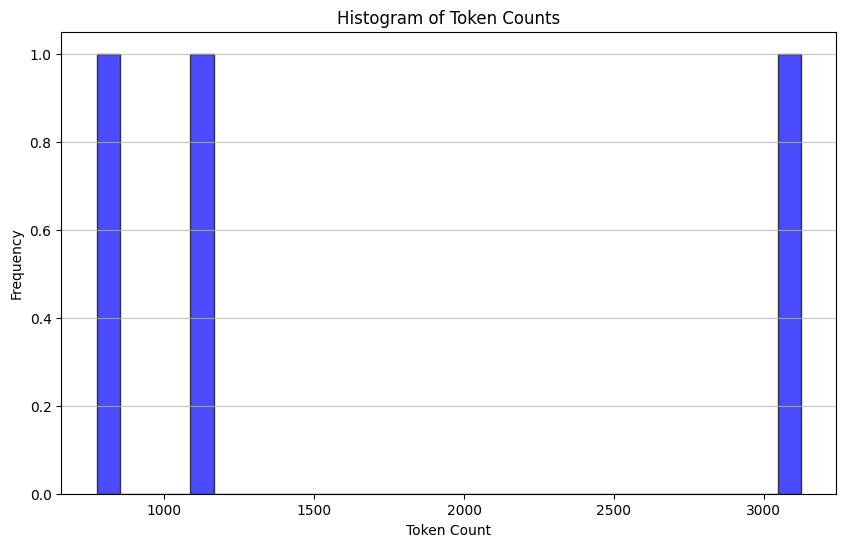

In [2]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# url = "https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/custom/"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
# )
# docs_dc = loader.load()

# Doc texts
docs.extend([*docs_pydantic, *docs_sq])#, *docs_dc])
docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [3]:
len(docs_texts)

3

In [4]:
docs_texts

['\n\n\n\n\nLangChain Expression Language (LCEL) | 🦜️🔗 LangChain\n\n\n\n\n\n\n\nSkip to main contentLangChain v0.2 is out! You are currently viewing the old v0.1 docs. View the latest docs here.ComponentsIntegrationsGuidesAPI ReferenceMorePeopleVersioningContributingTemplatesCookbooksTutorialsYouTubev0.1v0.2v0.1🦜️🔗LangSmithLangSmith DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS Docs💬SearchGet startedIntroductionQuickstartInstallationUse casesQ&A with RAGExtracting structured outputChatbotsTool use and agentsQuery analysisQ&A over SQL + CSVMoreExpression LanguageGet startedRunnable interfacePrimitivesAdvantages of LCELStreamingAdd message history (memory)MoreEcosystem🦜🛠️ LangSmith🦜🕸️LangGraph🦜️🏓 LangServeSecurityExpression LanguageLangChain Expression Language (LCEL)LangChain Expression Language, or LCEL, is a declarative way to easily compose chains together.\nLCEL was designed from day 1 to support putting prototypes in production, with no code changes, from the 

In [5]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 5060


In [6]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

In [7]:
texts_split

['Quickstart | 🦜️🔗 LangChain\n\n\n\n\n\n\n\nSkip to main contentLangChain v0.2 is out! You are currently viewing the old v0.1 docs. View the latest docs here.ComponentsIntegrationsGuidesAPI ReferenceMorePeopleVersioningContributingTemplatesCookbooksTutorialsYouTubev0.1v0.2v0.1🦜️🔗LangSmithLangSmith DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS Docs💬SearchModel I/OPromptsChat modelsLLMsOutput parsersQuickstartOutput ParsersCustom Output ParserstypesRetrievalDocument loadersText splittersEmbedding modelsVector storesRetrieversIndexingCompositionToolsAgentsChainsMoreComponentsModel I/OOutput parsersQuickstartOn this pageQuickstartLanguage models output text. But many times you may want to get more structured information than just text back. This is where output parsers come in.Output parsers are classes that help structure language model responses. There are two main methods an output parser must implement:"Get format instructions": A method which returns a string con

In [8]:
len(texts_split)

5

In [9]:
# model 
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_community.llms.ollama import Ollama

embd  = OllamaEmbeddings(model="llama3")
model = Ollama(model="llama3")

In [12]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Xác định số lượng cụm tối ưu bằng cách sử dụng  Bayesian Information Criterion (BIC) với Gaussian Mixture Model.
    
    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Thực hiện phân clustering trên các phần embeddings bằng cách trước tiên giảm kích thước của chúng trên toàn cầu, sau đó phân cụm
    sử dụng Gaussian Mixture Model và cuối cùng thực hiện phân cụm cục bộ trong mỗi cụm toàn cầu.
    
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them
    -> embed
    -> perform_clustering()  thực hiện phân cụm
    -> returning a DataFrame with texts, their embeddings, and cluster labels.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Phân cụm on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Định dạng tài liệu văn bản trong DataFrame thành một chuỗi.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Nhúng, nhóm và tóm tắt danh sách văn bản. 
    -> tạo ra các phần nhúng cho văn bản,
    -> phân cụm chúng dựa trên sự giống nhau, mở rộng phép gán cụm để xử lý dễ dàng hơn
    -> sau đó tóm tắt nội dung trong mỗi cụm.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could xác định độ sâu hoặc chi tiết xử lý.

    Returns:
    - Tuple containing two DataFrames:
      1. DataFrame đầu tiên (`df_clusters`) bao gồm các văn bản gốc, phần nhúng của chúng và các bài tập cụm.
      2. DataFrame thứ hai (`df_summary`) chứa các bản tóm tắt cho từng cụm, mức độ chi tiết được chỉ định,
         và các định danh cụm.
    """

    # Nhúng và phân cụm văn bản, tạo ra một DataFrame với các cột 'text', 'embd', and 'cluster'
    df_clusters = embed_cluster_texts(texts)
    print("df_clusters: \n", df_clusters)
    """
        data = {
            "text": ["Document 1", "Document 2", "Document 3"],
            "embd": [[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]],
            "cluster": [[1, 2], [1], [2, 3]]
        }
    """
    # Prepare to expand the DataFrame for thao tác các cụm dễ dàng hơn
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)
    # Số cụm được nhận dạng
    all_clusters = expanded_df["cluster"].unique()
    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc. 
    
    LangChain Expression Language provides a way to compose chain in LangChain.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Định dạng văn bản trong mỗi cụm để tóm tắt
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)                          # định dạng text trong dataframe thành chuỗi str
        summaries.append(chain.invoke({"context": formatted_txt}))   # tóm tắt

    # Tạo DataFrame để lưu trữ các bản tóm tắt với cụm và cấp độ tương ứng của chúng
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Đệ quy nhúng, phân cụm và tóm tắt văn bản ở mức độ cụ thể hoặc đến khi số cụm = 1
    kết quả được lưu trữ ở mỗi cấp độ
    
    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Thực hiện nhúng, phân cụm và tóm tắt cho cấp độ hiện tại
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)  # số cụm và tóm tắt

    # Lưu trữ kết quả của cấp độ hiện tạ
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Sử dụng tóm tắt làm văn bản đầu vào cho cấp độ đệ quy tiếp theo
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Hợp nhất các kết quả từ cấp độ tiếp theo vào từ điển kết quả hiện tại
        results.update(next_level_results)
    return results

In [14]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)
print("---------------------------")
print("results: \n", results)

df_clusters: 
                                                 text  \
0  \n\n\n\n\nLangChain Expression Language (LCEL)...   
1  \n\n\n\n\nQuickstart | 🦜️🔗 LangChain\n\n\n\n\n...   
2  \n\n\n\n\nSelf-querying | 🦜️🔗 LangChain\n\n\n\...   

                                                embd cluster  
0  [-0.182514950633049, -3.8791277408599854, -0.2...     [0]  
1  [-1.1084625720977783, -2.5549447536468506, -0....     [0]  
2  [-0.4645853042602539, -2.0416245460510254, -0....     [0]  
expanded_df: 
                                                 text  \
0  \n\n\n\n\nLangChain Expression Language (LCEL)...   
1  \n\n\n\n\nQuickstart | 🦜️🔗 LangChain\n\n\n\n\n...   
2  \n\n\n\n\nSelf-querying | 🦜️🔗 LangChain\n\n\n\...   

                                                embd  cluster  
0  [-0.182514950633049, -3.8791277408599854, -0.2...        0  
1  [-1.1084625720977783, -2.5549447536468506, -0....        0  
2  [-0.4645853042602539, -2.0416245460510254, -0....        0  
all_clusters

In [ ]:
from langchain_community.vectorstores import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Lặp lại các kết quả để trích xuất summaries từ mỗi cấp độ và thêm chúng vào all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [ ]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
rag_chain.invoke("How to define a RAG chain? Give me a specific code example.")

In [ ]:
print("..")